# Übung 3 - Collaborative Filtering

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix
from scipy.spatial.distance import pdist, squareform

import warnings; warnings.simplefilter('ignore')

Einlesen der Film Metadaten

In [2]:
movies = pd.read_csv('data/movies.csv', keep_default_na=False)

Einlesen der Ratings

In [3]:
ratings = pd.read_csv('data/ratings.csv')

In [4]:
# verwerfen aller Film mit weniger als 25 ratings
ratings = ratings.groupby('movieId').filter(lambda x: x['movieId'].count() > 25)

In [5]:
ratings

,userId,movieId,rating,timestamp,title
0,0,2852,2.5,1260759144,Dangerous Minds
1,0,1360,3.0,1260759182,Sleepers
2,0,1374,2.0,1260759185,Escape from New York
3,0,1545,3.0,1260759117,Blazing Saddles
4,0,2816,1.0,1260759200,Time Bandits
...,...,...,...,...,...
99805,670,1519,2.0,1064245565,High Fidelity
99806,670,941,4.0,1065149296,Dances with Wolves
99807,670,2052,4.0,1063502737,Animal House
99808,670,1533,4.0,1064245557,About a Boy


In [6]:
# movieIds anpassen
movies = movies[movies.movieId.isin(set(ratings.movieId))].reset_index(drop=True)

In [7]:
ratings['movieId'] = ratings.movieId.map({mi: i for i, mi in movies.movieId.items()})
movies['movieId'] = movies.movieId.map({mi: i for i, mi in movies.movieId.items()})

# Item similarity

In [8]:
# Ratings matrix erstellen
rat = coo_matrix(
    (ratings.rating, (ratings.movieId, ratings.userId)), 
    shape=(
        len(set(ratings.movieId)),
        len(set(ratings.userId))
    )
)
ratings_matrix = pd.DataFrame(
    rat.todense(), 
    columns=range(rat.shape[1]), 
    index=movies.title
)
ratings_matrix[ratings_matrix == 0] = np.nan
ratings_matrix.shape

(994, 671)

In [9]:
ratings_matrix

,0,1,2,3,4,5,6,7,8,9,...,661,662,663,664,665,666,667,668,669,670
title,,,,,,,,,,,,,,,,,,,,,
Inception,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
The Dark Knight,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Avatar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
The Avengers (2012),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Interstellar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bulworth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
Waking Ned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
Bob Roberts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Da die Pearson-Correlation nicht von pairwise_distance von sklearn unterstütz wird, können wir die selber implentieren und mit pdist von scipy die pairwist distances berechnen

Hinweis:\
Pairwise Distance von scipy: [scipy.spatial.distance.pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html), 
[scipy.spatial.distance.squareform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.squareform.html)\
Masked Arrays von Numpy: [numpy.ma](https://numpy.org/doc/stable/reference/maskedarray.generic.html)\
[numpy.isnan](https://numpy.org/doc/stable/reference/generated/numpy.isnan.html), [numpy.ma.array](https://numpy.org/doc/stable/reference/generated/numpy.ma.array.html), [numpy.nanmean](https://numpy.org/doc/stable/reference/generated/numpy.nanmean.html), [numpy.ma.dot](https://numpy.org/doc/stable/reference/generated/numpy.ma.dot.html) (Summe der Produkte der Vektoren entspricht dem dot-Produkt), np.ma.sqrt

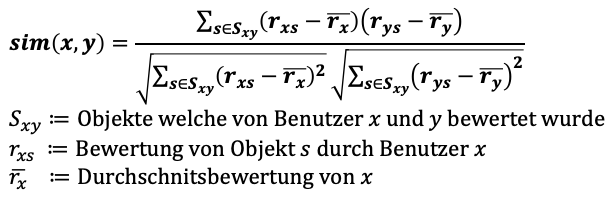

In [10]:
# Perason Correlation der Vektoren a und b
def pearson_correlation(a, b):
    m = np.isnan(a) | np.isnan(b)
    m_a = np.ma.array(a, mask=m)
    m_b = np.ma.array(b, mask=m)

    mean_a = np.nanmean(a)
    mean_b = np.nanmean(b)

    nominator = np.ma.dot((m_a - mean_a), (m_b - mean_b))
    denominator1 = np.ma.sqrt(np.ma.dot((m_a - mean_a), (m_a - mean_a)))
    denominator2 = np.ma.sqrt(np.ma.dot((m_b - mean_b), (m_b - mean_b)))
    denominator = denominator1 * denominator2
    return nominator / denominator

In [11]:
# Item similarity matrix berechnen (dauert einige Minuten)
sims = squareform(pdist(ratings_matrix, pearson_correlation)).round(2)
item_sim = pd.DataFrame(sims, index=movies.title, columns=movies.title)

In [12]:
# Die Ähnlichsten Filme von Toy Story
item_sim['Toy Story'].sort_values(ascending=False).head(10)

title
The Grand Budapest Hotel                           0.77
Toy Story 3                                        0.76
Jay and Silent Bob Strike Back                     0.75
Toy Story 2                                        0.73
Robin Hood                                         0.70
The Social Network                                 0.70
A Bug's Life                                       0.69
Master and Commander: The Far Side of the World    0.67
Delicatessen                                       0.67
White Men Can't Jump                               0.66
Name: Toy Story, dtype: float64

In [13]:
item_sim['Toy Story'].sort_values(ascending=False).tail(10)

title
The Intouchables             -0.27
Don Juan DeMarco             -0.27
Tank Girl                    -0.28
The Motorcycle Diaries       -0.28
Bulworth                     -0.29
The Godfather: Part III      -0.30
Die Another Day              -0.32
Emma                         -0.35
Good Night, and Good Luck.   -0.35
Repo Man                     -0.40
Name: Toy Story, dtype: float64

In [14]:
# Für diesen user möchten wir nun Recommendations machen
user_id = 5

In [15]:
# Zuerst schauen wir uns nur die Prediction für einen Film an
movie = movies.loc[movies.title == 'Toy Story'].squeeze()

In [16]:
# Ratings des Users filtern
user_ratings = ratings[ratings.userId == user_id]
user_ratings.sort_values('rating', ascending=False).head(10)

,userId,movieId,rating,timestamp,title
462,5,85,5.0,1108134539,Leon: The Professional
491,5,16,5.0,1108134519,The Lord of the Rings: The Return of the King
485,5,489,5.0,1108134266,Lawrence of Arabia
482,5,20,5.0,1108134311,The Lord of the Rings: The Two Towers
454,5,185,4.5,1108134521,Shaun of the Dead
470,5,298,4.5,1109258196,Stand by Me
488,5,726,4.5,1108134339,Heathers
480,5,626,4.5,1108134284,The Bridge on the River Kwai
460,5,723,4.5,1108134309,Cool Hand Luke
466,5,323,4.5,1108134545,The Iron Giant


In [17]:
item_sim[movie.title].sort_values(ascending=False)

title
The Grand Budapest Hotel          0.77
Toy Story 3                       0.76
Jay and Silent Bob Strike Back    0.75
Toy Story 2                       0.73
Robin Hood                        0.70
                                  ... 
The Godfather: Part III          -0.30
Die Another Day                  -0.32
Emma                             -0.35
Good Night, and Good Luck.       -0.35
Repo Man                         -0.40
Name: Toy Story, Length: 994, dtype: float64

In [18]:
# Filme sortiert nach Ähnlichkeit zu 'movie'
most_similar_items = item_sim[movie.title].sort_values(ascending=False)
most_similar_items.head(10)

title
The Grand Budapest Hotel                           0.77
Toy Story 3                                        0.76
Jay and Silent Bob Strike Back                     0.75
Toy Story 2                                        0.73
Robin Hood                                         0.70
The Social Network                                 0.70
A Bug's Life                                       0.69
Master and Commander: The Far Side of the World    0.67
Delicatessen                                       0.67
White Men Can't Jump                               0.66
Name: Toy Story, dtype: float64

In [19]:
# ratings vom User sortiert nach Ähnlichkeit der Filme
ratings_sorted_by_similarity = ratings_matrix[user_id][most_similar_items.index]
ratings_sorted_by_similarity.head(10)

title
The Grand Budapest Hotel                           NaN
Toy Story 3                                        NaN
Jay and Silent Bob Strike Back                     NaN
Toy Story 2                                        4.0
Robin Hood                                         NaN
The Social Network                                 NaN
A Bug's Life                                       NaN
Master and Commander: The Far Side of the World    NaN
Delicatessen                                       NaN
White Men Can't Jump                               NaN
Name: 5, dtype: float64

Hinweis: [pandas.notnull](https://pandas.pydata.org/docs/reference/api/pandas.notnull.html) 

In [20]:
# Filtere nach tatsächlichen Ratings vom User
rated_items = pd.notnull(ratings_sorted_by_similarity)
rated_items

title
The Grand Budapest Hotel          False
Toy Story 3                       False
Jay and Silent Bob Strike Back    False
Toy Story 2                        True
Robin Hood                        False
                                  ...  
The Godfather: Part III           False
Die Another Day                   False
Emma                              False
Good Night, and Good Luck.        False
Repo Man                          False
Name: 5, Length: 994, dtype: bool

In [21]:
# Bewertungen der Ähnlichsten Filme mit Bewertungen
ratings_sorted_by_similarity[rated_items][:10]

title
Toy Story 2                                 4.0
Cool Hand Luke                              4.5
Stand by Me                                 4.5
Spider-Man 2                                4.0
Lawrence of Arabia                          5.0
The Iron Giant                              4.5
Harry Potter and the Prisoner of Azkaban    3.5
Judge Dredd                                 2.0
Logan's Run                                 3.0
Vertigo                                     4.0
Name: 5, dtype: float64

In [22]:
# Ähnlichkeiten der Ähnlichsten Filme mit Bewertungen
most_similar_items[rated_items][:10]

title
Toy Story 2                                 0.73
Cool Hand Luke                              0.53
Stand by Me                                 0.50
Spider-Man 2                                0.50
Lawrence of Arabia                          0.48
The Iron Giant                              0.48
Harry Potter and the Prisoner of Azkaban    0.46
Judge Dredd                                 0.44
Logan's Run                                 0.44
Vertigo                                     0.39
Name: Toy Story, dtype: float64

Hinweis: [numpy.average](https://numpy.org/doc/stable/reference/generated/numpy.average.html)  

In [23]:
# Weighted average der 10 Ähnlichsten Filme mit einem Rating vom User
np.average(ratings_sorted_by_similarity[rated_items][:10], weights=most_similar_items[rated_items][:10].squeeze())

3.936363636363637

Jetzt können wir für alle Filme für einen Benutzer eine Approximation machen, in dem wir den Code von oben in einem Loop zusammenführen und für alle Filme die Approximation in einem neuen DataFrame speichern

Hinweis:\
[pandas.DataFrame.merge](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html)\
[pandas.DataFrame.iterrows](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iterrows.html)


In [24]:
# Neues DataFrame erstellen mit allen Filmen und den bestehenden Ratings des Users
user_recommendations = movies[['title']].merge(user_ratings[['title', 'rating']], how='left')
user_recommendations

,title,rating
0,Inception,NaN
1,The Dark Knight,NaN
2,Avatar,NaN
3,The Avengers (2012),NaN
4,Interstellar,NaN
...,...,...
989,Bulworth,NaN
990,Waking Ned,NaN
991,Bob Roberts,NaN
992,Forget Paris,NaN


In [25]:
# berechne für jeden Film für diesen User das predictete Rating
predictions = []
for i, movie in user_recommendations.iterrows():
    
    # Filme sortiert nach Ähnlichkeit zu 'movie'
    most_similar_items = item_sim[movie.title].sort_values(ascending=False)
    
    # ratings vom User sortiert nach Ähnlichkeit der Filme
    ratings_sorted_by_similarity = ratings_matrix[user_id][most_similar_items.index]
    
    # Filtere nach tatsächlichen Ratings vom User
    rated_items = pd.notnull(ratings_sorted_by_similarity)
    
    # Weighted average der 10 Ähnlichsten Filme mit einem Rating vom User
    predictions.append(np.average(ratings_sorted_by_similarity[rated_items][:10], weights=most_similar_items[rated_items][:10]))
    
user_recommendations['predictions'] = predictions

In [26]:
# Top 10 recommendations für User
user_recommendations.sort_values('predictions', ascending=False).head(10)

,title,rating,predictions
813,Election,NaN,4.169291
127,Braveheart,NaN,4.156766
71,Alien,NaN,4.088592
375,Citizen Kane,NaN,4.071429
858,Arsenic and Old Lace,NaN,4.060958
33,Finding Nemo,NaN,4.043152
48,Gladiator,NaN,4.038462
16,The Lord of the Rings: The Return of the King,5.0,4.035129
333,Final Destination,NaN,4.004491
917,The First Wives Club,NaN,3.994924
